<a href="https://colab.research.google.com/github/teekayvar/cs231n/blob/main/svmfinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = 'assignment1/cs231n'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/MyDrive/{}'.format(FOLDERNAME))
sys.path.append('/content/drive/MyDrive/assignment1/')

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/MyDrive/assignment1/cs231n/datasets
!bash get_datasets.sh
%cd /content

/content/drive/MyDrive/assignment1/cs231n/datasets
/content


# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [ ]:
# Run some setup code for this notebook.
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [ ]:
# Load the raw CIFAR-10 data.
cifar10_dir = '/content/drive/MyDrive/assignment1/cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


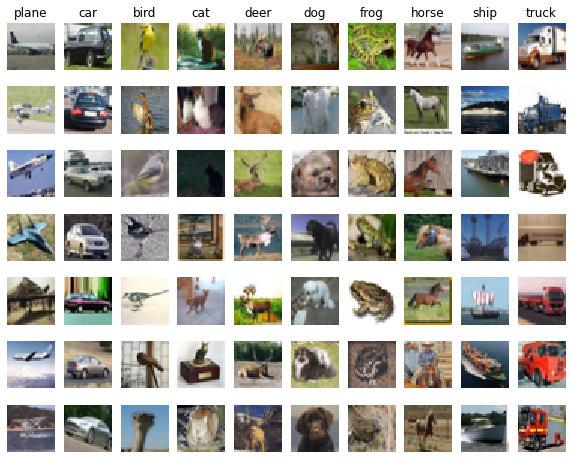

In [ ]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [ ]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [ ]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


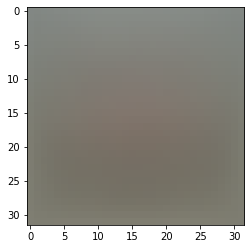

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


In [ ]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

## SVM Classifier

Your code for this section will all be written inside `cs231n/classifiers/linear_svm.py`. 

As you can see, we have prefilled the function `svm_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [ ]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 9.323883


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [ ]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 38.178828 analytic: 38.178828, relative error: 2.713191e-12
numerical: 17.687002 analytic: 17.687002, relative error: 3.412509e-12
numerical: -5.255100 analytic: -5.222441, relative error: 3.116967e-03
numerical: 26.085101 analytic: 26.085101, relative error: 5.303172e-12
numerical: -0.215406 analytic: -0.215406, relative error: 1.499598e-10
numerical: -0.189093 analytic: -0.189093, relative error: 8.601487e-10
numerical: 5.112540 analytic: 5.112540, relative error: 6.305687e-11
numerical: -5.744596 analytic: -5.744596, relative error: 3.111248e-11
numerical: -30.094227 analytic: -30.094227, relative error: 8.450706e-12
numerical: -2.737322 analytic: -2.737322, relative error: 8.812122e-11
numerical: 4.568839 analytic: 4.568161, relative error: 7.428836e-05
numerical: -6.647265 analytic: -6.649372, relative error: 1.584263e-04
numerical: -5.252390 analytic: -5.211082, relative error: 3.947806e-03
numerical: 0.086573 analytic: 0.087927, relative error: 7.757717e-03
numerical:

**Inline Question 1**

It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? How would change the margin affect of the frequency of this happening? *Hint: the SVM loss function is not strictly speaking differentiable*

$\color{blue}{\textit Your Answer:}$ 

Yes, such a situation is possible. In the SVM loss function, max(0, x) x is is the delta between the scores of incorrect classes and correct class plus delta. If x > 0, we incur a loss, else if x < 0, we put the output to 0. When the analytical and numerical gradients do not match, the SVM loss function may not work properly, for example, when its gradient is undefined at the hinge(x = 0). Usually, when max(x, y) at x = y, the gradient is undefined. These non-differentiable parts of the function are called kinks and they lead to failed gradchecks.

However, this is not an issue as the gradient descent practice still works everywhere except at the hinge in the case of the SVM. Therefore, we can skip this point at which we cannot compute the gradient.



In [ ]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 9.323883e+00 computed in 0.141810s
[[ -88.64189796  -76.98173469  -79.47391837 ...  -39.86195918
   -25.39957143    1.        ]
 [  77.35810204   71.01826531   81.52608163 ...  128.13804082
   138.60042857    1.        ]
 [  14.35810204   12.01826531   30.52608163 ... -125.86195918
  -103.39957143    1.        ]
 ...
 [ -20.64189796  -33.98173469  -56.47391837 ...   -9.86195918
   -17.39957143    1.        ]
 [ -15.64189796   11.01826531   70.52608163 ...  -55.86195918
   -49.39957143    1.        ]
 [ -86.64189796  -77.98173469  -77.47391837 ...   47.13804082
    42.60042857    1.        ]]
Vectorized loss: 8.616000e+00 computed in 0.020884s
difference: 0.707883


In [ ]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.142032s
[[ -88.64189796  -76.98173469  -79.47391837 ...  -39.86195918
   -25.39957143    1.        ]
 [  77.35810204   71.01826531   81.52608163 ...  128.13804082
   138.60042857    1.        ]
 [  14.35810204   12.01826531   30.52608163 ... -125.86195918
  -103.39957143    1.        ]
 ...
 [ -20.64189796  -33.98173469  -56.47391837 ...   -9.86195918
   -17.39957143    1.        ]
 [ -15.64189796   11.01826531   70.52608163 ...  -55.86195918
   -49.39957143    1.        ]
 [ -86.64189796  -77.98173469  -77.47391837 ...   47.13804082
    42.60042857    1.        ]]
Vectorized loss and gradient: computed in 0.019735s
difference: 3000.840228


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss. Your code for this part will be written inside `cs231n/classifiers/linear_classifier.py`.

In [ ]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

Streaming output truncated to the last 5000 lines.
 [  88.35810204   80.01826531   73.52608163 ...   70.13804082
    72.60042857    1.        ]
 [ -31.64189796  -20.98173469  -44.47391837 ...   46.13804082
     3.60042857    1.        ]]
[[-128.64189796 -135.98173469 -131.47391837 ... -123.86195918
  -112.39957143    1.        ]
 [  25.35810204   20.01826531  -24.47391837 ...  -78.86195918
   -78.39957143    1.        ]
 [ -67.64189796  -79.98173469  -61.47391837 ...  -77.86195918
   -52.39957143    1.        ]
 ...
 [  39.35810204   37.01826531   42.52608163 ...  -80.86195918
   -89.39957143    1.        ]
 [   9.35810204  -96.98173469 -103.47391837 ... -121.86195918
  -110.39957143    1.        ]
 [  92.35810204   90.01826531   96.52608163 ...  -22.86195918
    -4.39957143    1.        ]]
[[-120.64189796 -125.98173469 -122.47391837 ...  -16.86195918
   -42.39957143    1.        ]
 [ -28.64189796  -39.98173469  -56.47391837 ...  -14.86195918
   -58.39957143    1.        ]
 [  49.35810

In [ ]:
X_train

array([[ -71.64189796,  -73.98173469,  -69.47391837, ...,  -33.86195918,
         -42.39957143,    1.        ],
       [  23.35810204,   41.01826531,   54.52608163, ...,    7.13804082,
          29.60042857,    1.        ],
       [ 124.35810204,  119.01826531,  122.52608163, ...,  -39.86195918,
         -30.39957143,    1.        ],
       ...,
       [ -69.64189796,  -62.98173469,  -56.47391837, ...,   34.13804082,
           2.60042857,    1.        ],
       [-120.64189796, -131.98173469, -118.47391837, ...,   48.13804082,
          90.60042857,    1.        ],
       [  44.35810204,   57.01826531,   96.52608163, ...,  -47.86195918,
         -24.39957143,    1.        ]])

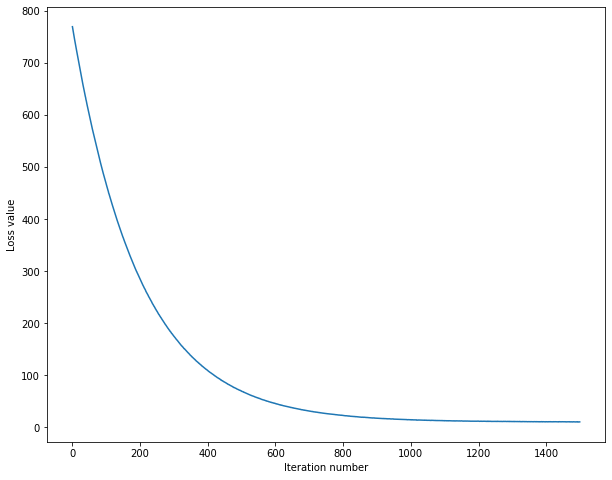

In [ ]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [ ]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.363163
validation accuracy: 0.379000


In [ ]:
results = {}
best_val = -1 
best_svm = None

learning_rates = [1e-8, 2e-7, 1e-7, 3e-5] 
regularization_strengths = [0.5e4, 1e4, 2e4, 2.5e4, 3e4, 3.5e4, 4e4]

grid_search = [(lr, reg) for lr in learning_rates \
for reg in regularization_strengths]

for config_num, config in enumerate(grid_search):
  print("Hyperparam config #{} of #{}".format(config_num+1, len(grid_search)))
  print("Hyperparam config: {}".format(config))
  lr, reg = config
  svm = LinearSVM()

  loss_hist = svm.train(X_train, y_train, learning_rate=lr,
                  reg=reg, num_iters=1500, verbose=False)
  
  y_train_pred = svm.predict(X_train)
  y_val_pred = svm.predict(X_val)

  current_y_train_accuracy = np.mean(y_train_pred == y_train)
  current_y_val_accuracy = np.mean(y_val_pred == y_val)

  results[(lr, reg)] = (current_y_train_accuracy, current_y_val_accuracy)

  if current_y_val_accuracy > best_val:
    best_val = current_y_val_accuracy
    best_svm = svm

for lr, reg in sorted(results):
  train_accuracy, val_accuracy = results[(lr, reg)]
  print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
        lr, reg, train_accuracy, val_accuracy))
  
print('best validation accuracy achieved during cross-validation: %f' % best_val)






Streaming output truncated to the last 5000 lines.
    41.60042857    1.        ]
 [ -47.64189796  -75.98173469  -79.47391837 ...  -92.86195918
   -85.39957143    1.        ]
 [ -59.64189796  -79.98173469  -85.47391837 ...   22.13804082
    14.60042857    1.        ]]
[[ -52.64189796  -50.98173469  -52.47391837 ...   18.13804082
    25.60042857    1.        ]
 [ -67.64189796  -75.98173469  -65.47391837 ...  -70.86195918
   -51.39957143    1.        ]
 [ -68.64189796  -40.98173469   -6.47391837 ...  -38.86195918
    -1.39957143    1.        ]
 ...
 [  96.35810204   98.01826531  119.52608163 ...  103.13804082
    96.60042857    1.        ]
 [-129.64189796 -133.98173469 -132.47391837 ...  -83.86195918
   -79.39957143    1.        ]
 [  82.35810204   64.01826531   41.52608163 ...  -58.86195918
   -52.39957143    1.        ]]
[[  16.35810204   18.01826531  -10.47391837 ...  -23.86195918
    -2.39957143    1.        ]
 [ -29.64189796   23.01826531   11.52608163 ...  -25.86195918
   -31.39957

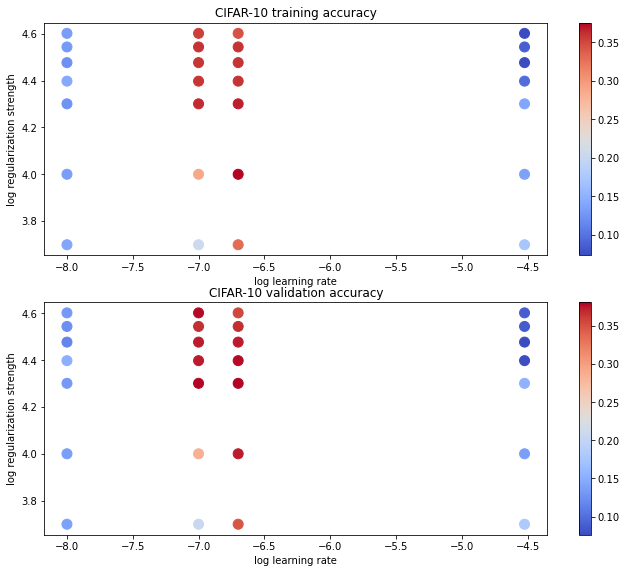

In [ ]:
# Visualize the cross-validation results
import math
import pdb

# pdb.set_trace()

x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.tight_layout(pad=3)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [ ]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.360000


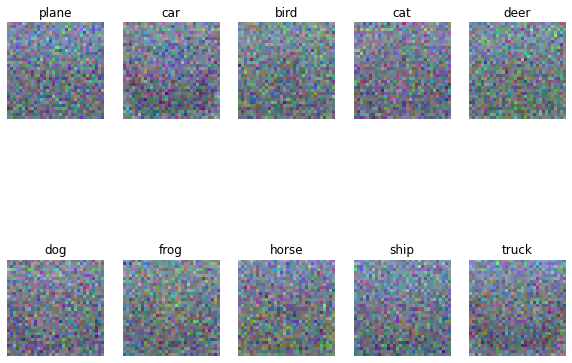

In [ ]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

**Inline question 2**

Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

$\color{blue}{\textit Your Answer:}$ 

The visualised SVM weights appear to represent the templates for each class, and look like a combination of images of each class. For example, the weights of the class 'truck' don't actually look like a truck, but a combination of pixels from the images of trucks. In addition, the reason why the images are blur is because the accuracy obtained was low(in this case, 36%). This approach differs from K-nearest neighbour in the sense that in KNN, we compare the test image with all the training images using L1/L2 distances. In SVM, however, we compare the templates of each class by using the inner product.
